In [1]:
cd ..

/Users/amiyaguchi/wikipedia-retention


In [2]:
from pyspark.sql import SparkSession, Row, functions as F, types as T
import pandas as pd
import numpy as np

spark = SparkSession.builder.getOrCreate()

# read the network for 2007Q1
snapshot = spark.read.csv(
    "data/processed/2007-1-user-network-v3.csv",
    sep='\t',
    schema="src INT, dst INT, weight INT"
)

# read the role distribution information
roleG = pd.read_csv("data/processed/roles/2007-1-nmf-G.csv")

x = roleG.apply(lambda x: Row(
    user_id=int(x[0]), 
    vec=x[1:].astype(float).tolist()
), axis=1).values

rolx_df = spark.createDataFrame(list(x))

In [34]:
# generate features

enwiki = spark.read.parquet("data/processed/enwiki-meta-compact")

user_text = (
    enwiki
    .where("year=2007 and quarter=1")
    .groupby("user_id")
    .agg(
        F.expr("count(distinct article_id) as n_articles"),
        F.expr("count(*) as n_edits"),
        F.expr("sum(log(textdata)) as edit_count")
    )
)

In [289]:
from sklearn.decomposition import NMF

rolx_vec = pd.read_csv(
    "data/processed/roles/2007-1-v", 
    header=None, 
    sep=" "
)
rolx_mapping = pd.read_csv(
    "data/processed/roles/2007-1-mappings", 
    header=None, 
    skiprows=1, 
    sep=" "
)
df = pd.concat([rolx_mapping, rolx_vec], axis=1).iloc[:, 1:]

nmf = NMF(n_components=8,
          solver="mu", 
          beta_loss="kullback-leibler",
          tol=1e-6,
          max_iter=1000)

X = df.values[:, 1:]
W = nmf.fit_transform(X)
roleG = pd.concat([df.iloc[:, 0], pd.DataFrame(W)], axis=1)
x = roleG.apply(lambda x: Row(
    user_id=int(x[0]), 
    vec=x[1:].astype(float).tolist()
), axis=1).values
rolx_df = spark.createDataFrame(list(x))

In [290]:
edgelist = (
    snapshot
    .union(snapshot.selectExpr("dst as src", "src as dst", "weight"))
    .distinct()
)

@F.udf(T.ArrayType(T.FloatType()))
def average_vec(vecs):
    avg = np.array(vecs).sum(axis=0)/len(vecs)
    return avg.astype(float).tolist()

neighbors = (
    edgelist
    .join(rolx_df.selectExpr("user_id as dst", "vec"), on="dst")
    .groupby("src")
    .agg(F.collect_list("vec").alias("vec_list"))
    .withColumn("neighborhood_roles", average_vec("vec_list"))
    .selectExpr("src as user_id", "neighborhood_roles")
)

In [291]:
df = (
    user_text
    .join(rolx_df, on="user_id", how="inner")
    .join(neighbors, on="user_id", how="inner")
    .select(
        "user_id",
        F.array("n_articles", "n_edits", "edit_count").alias("features"),
        F.expr("vec as roles"),
        "neighborhood_roles"
    )
).toPandas()

In [292]:
from sklearn.decomposition import non_negative_factorization

In [293]:
# Sensing
print(df.shape)
df.head()

(21175, 4)


,user_id,features,roles,neighborhood_roles
0,1591,"[507.0, 626.0, 4059.231716292192]","[1591.650904411446, 1614.9057464039424, 0.0, 1...","[1026.5643310546875, 1443.28515625, 282.127807..."
1,1591,"[507.0, 626.0, 4059.231716292192]","[1591.908361811882, 1612.5630148471107, 0.0, 7...","[1026.5643310546875, 1443.28515625, 282.127807..."
2,1591,"[507.0, 626.0, 4059.231716292192]","[1591.803772082812, 1542.0965600039221, 588.58...","[1026.5643310546875, 1443.28515625, 282.127807..."
3,1591,"[507.0, 626.0, 4059.231716292192]","[1591.4463764874363, 1502.6891936742527, 628.0...","[1026.5643310546875, 1443.28515625, 282.127807..."
4,1591,"[507.0, 626.0, 4059.231716292192]","[1591.4315034591712, 1500.5521517084192, 787.2...","[1026.5643310546875, 1443.28515625, 282.127807..."


In [294]:
features = np.array(list(df.features))
features.shape

(21175, 3)

In [295]:
roles = np.array(list(df.roles))
roles.shape

(21175, 8)

In [296]:
neighborhood_roles = np.array(list(df.roles))
neighborhood_roles.shape

(21175, 8)

In [306]:
# W (n x r) dot H (r x f) = M (n x f)
# f x n = (f x r) dot (r x n) 

W, _, _ = non_negative_factorization(
    X = features.T,
    H = roles.T,
    n_components=roles.shape[1],
    update_H = False,
    solver='mu', 
    beta_loss="kullback-leibler", 
    init='custom',
    tol=10e-6,
    max_iter=1000
)
W.shape

(3, 8)

In [307]:
W_def, _, _ = non_negative_factorization(
    X = features.T,
    H = np.ones((1, roles.shape[0])),
    n_components=1,
    update_H = False,
    solver='mu', 
    beta_loss="kullback-leibler", 
    init='custom',
    tol=10e-6,
    max_iter=1000
)
W_def.shape

(3, 1)

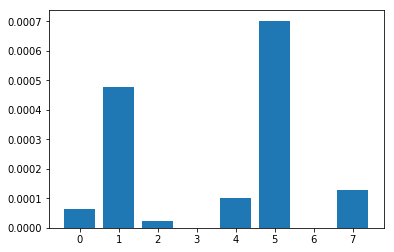

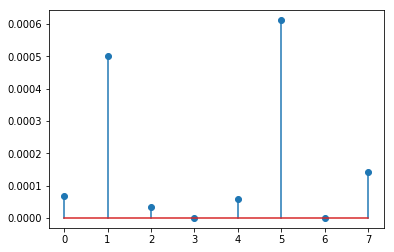

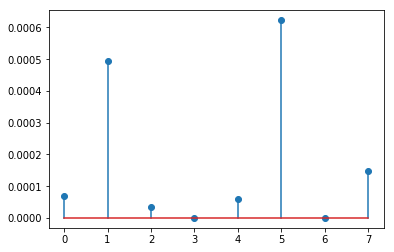

In [308]:
import matplotlib.pyplot as plt

W = W/W_def
plt.bar(np.arange(W.shape[1]), W[0])
plt.show()
plt.stem(np.arange(W.shape[1]), W[1])
plt.show()
plt.stem(np.arange(W.shape[1]), W[2])
plt.show()

In [300]:
W, _, _ = non_negative_factorization(
    X = neighborhood_roles.T,
    H = roles.T,
    n_components=roles.shape[1],
    update_H = False,
    solver='mu', 
    beta_loss="kullback-leibler", 
    init='custom',
    tol=10e-6,
    max_iter=1000
)

In [301]:
W_def, _, _ = non_negative_factorization(
    X = neighborhood_roles.T,
    H = np.ones((1, roles.shape[0])),
    n_components=1,
    update_H = False,
    solver='mu', 
    beta_loss="kullback-leibler", 
    init='custom',
    tol=10e-6,
    max_iter=1000
)

In [302]:
W_def

array([[ 932.03625513],
       [1453.71973065],
       [ 250.31770111],
       [  37.74073485],
       [ 365.96798821],
       [ 276.21575412],
       [  30.96345305],
       [  80.61744342]])

In [303]:
W

array([[9.95179037e-001, 8.24536122e-005, 7.94655682e-003,
        2.05734434e-007, 3.64249697e-012, 6.77391301e-010,
        2.52388893e-003, 2.86058189e-002],
       [5.29510279e-051, 9.99898591e-001, 3.89181127e-009,
        1.05441343e-004, 5.34747664e-005, 1.69261426e-009,
        4.00050550e-003, 3.19748332e-148],
       [2.67608021e-094, 9.45571279e-202, 1.00000000e+000,
        0.00000000e+000, 2.09628766e-310, 3.48109358e-169,
        2.22387335e-205, 1.55082193e-251],
       [3.09216479e-197, 0.00000000e+000, 3.68378546e-190,
        9.99999991e-001, 0.00000000e+000, 0.00000000e+000,
        1.12293072e-008, 0.00000000e+000],
       [1.45179506e-097, 4.02444657e-127, 1.84544787e-091,
        3.66996881e-173, 1.00000000e+000, 1.27275770e-092,
        7.93111037e-158, 4.38742515e-124],
       [1.79328071e-076, 2.12554570e-062, 6.74061030e-051,
        2.99449043e-136, 4.07635666e-128, 1.00000000e+000,
        1.27479819e-098, 1.35780743e-064],
       [5.48053984e-237, 4.7832817

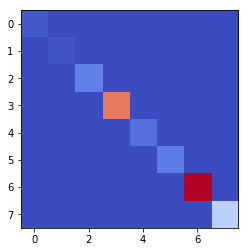

In [304]:
plt.imshow((W/W_def).T, cmap="coolwarm")